In [80]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles, make_moons
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors


class DBSCAN:
    def __init__(self, eps, min_samples):
        self.eps = eps
        self.min_samples = min_samples

    def fit(self, X):
        self.labels_ = np.full(X.shape[0], -1)
        cluster_label = 0

        for i in range(X.shape[0]):
            if self.labels_[i] != -1:
                continue

            neighbors = self.region_query(X, i)
            if len(neighbors) < self.min_samples:
                self.labels_[i] = -1  # Шум
            else:
                self.expand_cluster(X, i, neighbors, cluster_label)
                cluster_label += 1

        return self

    def expand_cluster(self, X, i, neighbors, cluster_label):
        self.labels_[i] = cluster_label
        queue = list(neighbors)

        while queue:
            j = queue.pop(0)
            if self.labels_[j] == -1:
                self.labels_[j] = cluster_label
            elif self.labels_[j] != -1:
                continue

            self.labels_[j] = cluster_label
            new_neighbors = self.region_query(X, j)
            if len(new_neighbors) >= self.min_samples:
                queue.extend(new_neighbors)

    def region_query(self, X, i):
        neighbors = []
        for j in range(X.shape[0]):
            if np.linalg.norm(X[i] - X[j]) <= self.eps:
                neighbors.append(j)
        return neighbors

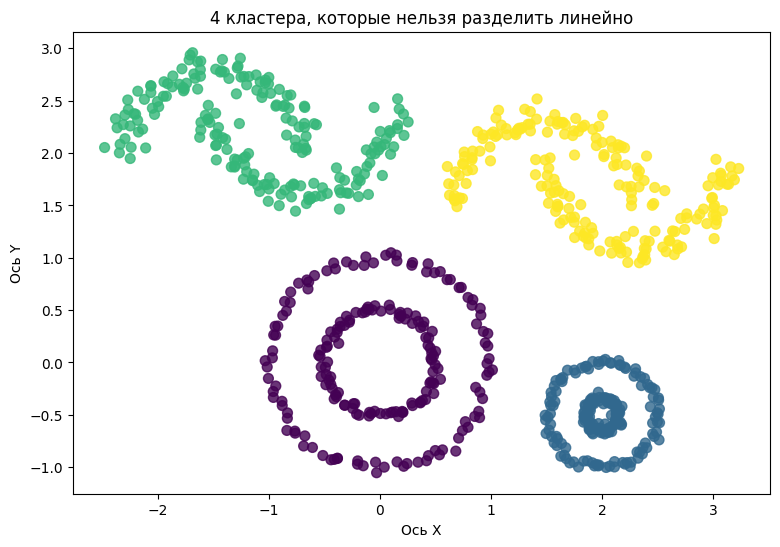

In [81]:
# 2D
np.random.seed(40)

# Первый кластер: круг
cluster1, _ = make_circles(n_samples=200, factor=0.5, noise=0.03)

# Второй кластер: круг внутри первого
cluster2, _ = make_circles(n_samples=200, factor=0.3, noise=0.05)
cluster2 = cluster2 * 0.5 + np.array([2, -0.5])  # Сдвигаем и уменьшаем

# Третий кластер: полумесяц
cluster3, _ = make_moons(n_samples=200, noise=0.1)
cluster3 = cluster3 * 0.8 + np.array([-1.5, 2])  # Сдвигаем и масштабируем

# Четвертый кластер: полумесяц
cluster4, _ = make_moons(n_samples=200, noise=0.1)
cluster4 = cluster4 * 0.8 + np.array([1.5, 1.5])  # Сдвигаем и масштабируем

# Объединяем все кластеры
X_2d = np.vstack([cluster1, cluster2, cluster3, cluster4])
y_2d = np.hstack([np.zeros(200), np.ones(200), np.ones(200) * 2, np.ones(200) * 3])

# Визуализация
plt.figure(figsize=(9, 6))
plt.scatter(X_2d[:, 0], X_2d[:, 1], c=y_2d, cmap='viridis', s=50, alpha=0.8)
plt.title("4 кластера, которые нельзя разделить линейно")
plt.xlabel("Ось X")
plt.ylabel("Ось Y")
plt.show()


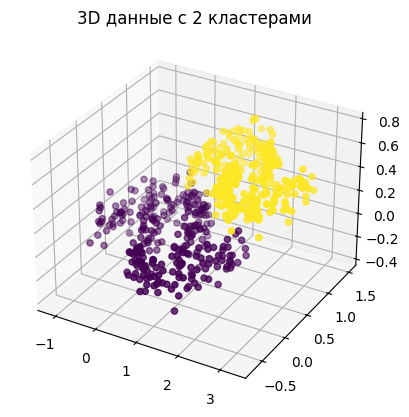

In [82]:
# 3D
np.random.seed(77)
# Первый кластер: трёхмерный "полумесяц"
cluster1, _ = make_moons(n_samples=300, noise=0.1)
# Добавляем третье измерение (Z) для первого кластера
z1 = np.random.normal(0, 0.1, size=cluster1.shape[0])  # Случайные значения по оси Z
cluster1 = np.column_stack((cluster1, z1))

# Второй кластер: трёхмерный "полумесяц", сдвинутый и повёрнутый
cluster2, _ = make_moons(n_samples=300, noise=0.1)
# Добавляем третье измерение (Z) для второго кластера
z2 = np.random.normal(0, 0.1, size=cluster2.shape[0])  # Случайные значения по оси Z
cluster2 = np.column_stack((cluster2, z2))
# Сдвигаем и поворачиваем второй кластер
cluster2 = cluster2 @ np.array([[0.8, 0, 0], [0, 0.8, 0], [0, 0, 1]]) + np.array([1.5, 0.5, 0.5])

# Объединяем кластеры
X_3d = np.vstack([cluster1, cluster2])
y_3d = np.hstack([np.zeros(300), np.ones(300)])  # Метки кластеров

# Визуализация 3D данных
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_3d[:, 0], X_3d[:, 1], X_3d[:, 2], c=y_3d, cmap='viridis')
ax.set_title("3D данные с 2 кластерами")
plt.show()

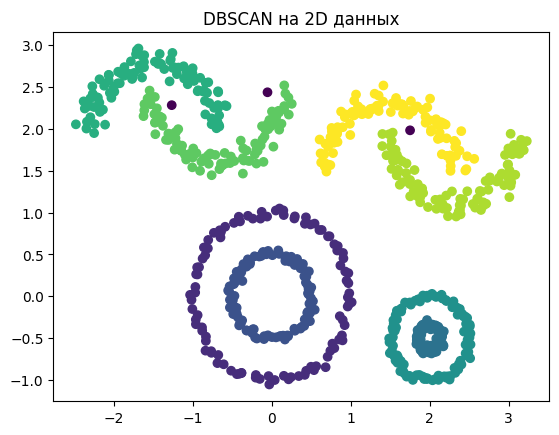

In [83]:
# DBSCAN 2D

dbscan_1 = DBSCAN(eps=0.165, min_samples=4)
dbscan_1.fit(X_2d)

# Визуализация результата DBSCAN для 2D данных
plt.scatter(X_2d[:, 0], X_2d[:, 1], c=dbscan_1.labels_, cmap='viridis')
plt.title("DBSCAN на 2D данных")
plt.show()


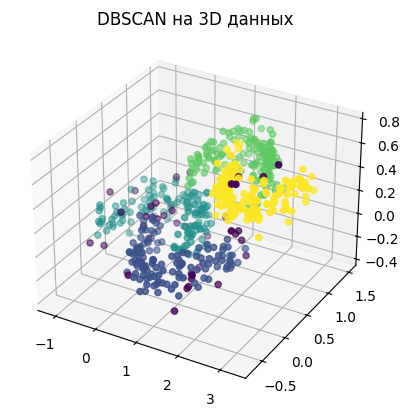

In [84]:
# DBSCAN 3D

dbscan_2 = DBSCAN(eps=0.175, min_samples=5)
dbscan_2.fit(X_3d)

# Визуализация результата DBSCAN для 3D данных
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_3d[:, 0], X_3d[:, 1], X_3d[:, 2], c=dbscan_2.labels_, cmap='viridis')
ax.set_title("DBSCAN на 3D данных")
plt.show()

In [85]:
# Для 2D данных
score_2d = silhouette_score(X_2d, dbscan_1.labels_)
print(f"Силуэт для 2D данных: {score_2d}")

# Для 3D данных
score_3d = silhouette_score(X_3d, dbscan_2.labels_)
print(f"Силуэт для 3D данных: {score_3d}")


Силуэт для 2D данных: 0.21660521385264875
Силуэт для 3D данных: 0.2074323730307756


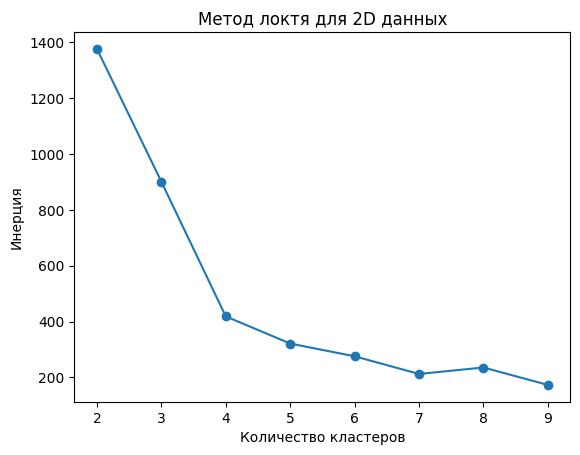

Оптимальное количество кластеров для 2D данных: 4


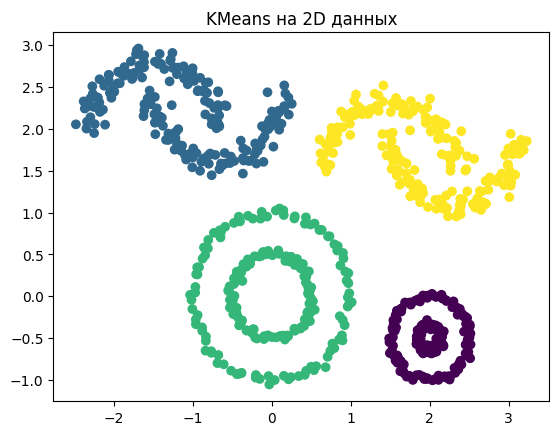

Силуэт DBSCAN: 0.21660521385264875, Силуэт KMeans: 0.5779143635039022


In [87]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Метод локтя для 2D данных
inertia = []
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_2d)
    inertia.append(kmeans.inertia_)

plt.plot(range(2, 10), inertia, marker='o')
plt.title("Метод локтя для 2D данных")
plt.xlabel("Количество кластеров")
plt.ylabel("Инерция")
plt.show()

# Оптимальное количество кластеров по силуэту
best_k = 0
best_score = -1
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_2d)
    score = silhouette_score(X_2d, kmeans.labels_)
    if score > best_score:
        best_score = score
        best_k = k

print(f"Оптимальное количество кластеров для 2D данных: {best_k}")

# Применение KMeans с оптимальным количеством кластеров
kmeans = KMeans(n_clusters=best_k, random_state=42)
kmeans.fit(X_2d)

# Визуализация результата KMeans
plt.scatter(X_2d[:, 0], X_2d[:, 1], c=kmeans.labels_, cmap='viridis')
plt.title("KMeans на 2D данных")
plt.show()

# Сравнение силуэтов
dbscan_1score = silhouette_score(X_2d, dbscan_1.labels_)
kmeans_score = silhouette_score(X_2d, kmeans.labels_)
print(f"Силуэт DBSCAN: {dbscan_1score}, Силуэт KMeans: {kmeans_score}")

Вот тут можно объяснить, почему